## Autoreload

In [1]:
%load_ext autoreload
%autoreload 2

## Libraries

In [11]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pywt
from scipy import signal
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import detrend, butter, filtfilt
import ipywidgets as widgets
from IPython.display import display
#from epy_signal import plot, settings, utils, vibrations

## Parameters

### Accceleration data

**File name and location**

In [3]:
def get_file_location(file_name: str):
    notebook_location = pathlib.Path().absolute()
    parent_directory = notebook_location.parent
    data_folder = parent_directory / 'tests/test_data'
    file_location = data_folder / file_name
    return file_location

In [ ]:
file_name = 'acceleration.txt'
file_location = utils.get_file_location(file_name)

In [7]:
file_location

WindowsPath('c:/Users/ingah/estructuraPy/signal_epy/tests/test_data/acceleration.txt')


**Import acceleration data**

In [8]:
def import_acceleration_data(file_location: str, label: str) -> pd.DataFrame:
    """
    Processes acceleration data from a file and returns a Pandas DataFrame.

    Args:
        file_location: The path to the file containing the acceleration data.
        label: The label to return as series. X, Y or Z.

    Returns:
        A Pandas DataFrame containing the time and acceleration data.

    Assumptions:
        - The file exists and is readable.
        - The file encoding is 'latin1'.
        - The file contains at least two lines, with the second line being a header.
        - Each data line has at least 5 fields, with the 2nd, 3rd, 4th and 5th fields representing time, x, y, and z accelerations respectively.
    """
    try:
        with open(file_location, "r", encoding="latin1") as file:
            # Reads lines and skips the header
            lines = [line.strip() for line in file.readlines()[1:]]
    except FileNotFoundError as e:
        raise FileNotFoundError(f"File not found: {file_location}") from e
    except Exception as e:
        raise IOError(f"Error reading file: {file_location}") from e

    times = []
    accelerations = []

    for line in lines:
        fields = line.split()
        # Checks if the line has enough fields
        if len(fields) >= 5:
            try:
                time = float(fields[1])
                if label.upper() == "X":
                    acceleration = float(fields[2])
                elif label.upper() == "Y":
                    acceleration = float(fields[3])
                elif label.upper() == "Z":
                    acceleration = float(fields[4])
                else:
                    raise ValueError(
                        "Direction must be X, Y, or Z (case-insensitive)."
                    )
                times.append(time)
                accelerations.append(acceleration * 9.81)
            except ValueError as e:
                print(f"Skipping line due to invalid data: {line}. Error: {e}")  # Errores: Invalid data

    times = np.array(times)
    accelerations = np.array(accelerations)

    return pd.DataFrame({"Time": times, f"{label} Acceleration": accelerations})

In [9]:
label ='Z'
label_corrected = f'{label} Corrected'
label_filtered = f'{label_corrected} Filtered'

threshold_percentage = 0.5

In [ ]:
df = import_acceleration_data(file_location, label)

Skipping line due to invalid data: POSITION       Time             ATb1116X         ATb1116Y         ATb1116Z         IW4-0778-0-CHAN-4ATb1106X         ATb1106Y         ATb1106Z         IW4-0777-0-CHAN-4. Error: could not convert string to float: 'Time'


In [ ]:
def plot_acceleration(df: pd.DataFrame, label: str, color: str = "red"):
    """
    Plots the acceleration signal from a DataFrame.

    Args:
        df: DataFrame containing 'Time' and '{label} Acceleration' columns.
        label: Direction of the acceleration signal to plot.
        color: Color of the plot line (default is 'red').

    Returns:
        None
    """
    plt.figure(figsize=(15, 6))
    plt.plot(
        df["Time"],
        df[f"{label} Acceleration"],
        color=color,
        linestyle="-",
        label=label,
    )

    plt.title(f"{label} Acceleration")
    plt.xlabel("Time (s)")
    plt.ylabel(r"Acceleration ($m/s^{2}$)")
    plt.legend()
    plt.show()

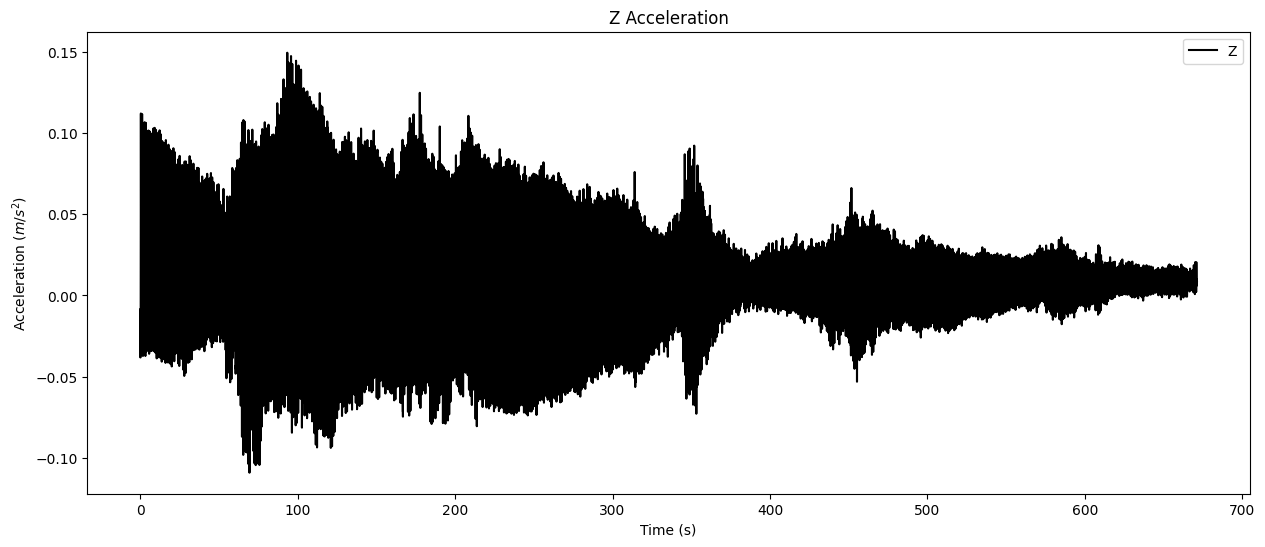

In [ ]:
plot.acceleration(df, label, color='k')

## FFT analysis

In [ ]:
def plot_normalized_fft(df_fft: pd.DataFrame, label: str, color: str = "red") -> None:
    """
    Plots the normalized FFT magnitude spectrum from a DataFrame.

    Args:
        df_fft: DataFrame containing '{label} Frequency' and '{label} Magnitude' columns.
        label: The label of the vibration (e.g., 'X', 'Y', 'Z').
        color: Color of the plot line (default is 'red').

    Returns:
        None

    Assumptions:
        - 'df_fft' contains '{label} Frequency' and '{label} Magnitude' columns.
    """
    frequencies = df_fft["Frequency"]
    magnitudes = df_fft[f"{label} Magnitude"]

    plt.figure(figsize=(10, 6))
    plt.plot(
        frequencies[:],
        magnitudes[:] / max(magnitudes[:]),
        color=color,
        linestyle="-",
        label=label,
    )
    plt.title("FFT Normalized Magnitude Spectrum ")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

In [ ]:
def plot_fft(df_fft: pd.DataFrame, label: str, color: str = "red") -> None:
    """
    Plots the FFT magnitude spectrum from a DataFrame.

    Args:
        df_fft: DataFrame containing '{label} Frequency' and '{label} Magnitude' columns.
        label: The label of the vibration (e.g., 'X', 'Y', 'Z').
        color: Color of the plot line (default is 'red').

    Returns:
        None

    Assumptions:
        - 'df_fft' contains '{label} Frequency' and '{label} Magnitude' columns.
    """
    frequencies = df_fft[f"Frequency"]
    magnitudes = df_fft[f"{label} Magnitude"]

    plt.figure(figsize=(10, 6))
    plt.plot(frequencies[:], magnitudes[:], color=color, linestyle="-", label=label)
    plt.title("FFT Magnitude Spectrum ")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

In [ ]:
def calculate_fft(df: pd.DataFrame, label: str) -> pd.DataFrame:
    """
    Calculates the FFT of a single acceleration data column and returns a DataFrame with the results.

    Args:
        df: DataFrame containing 'Time' and '{label} Acceleration' columns.
        label: The label of the vibration (e.g., 'X', 'Y', 'Z').

    Returns:
        DataFrame containing the FFT results with 'Frequency' and '{label} Magnitude' columns.

    Assumptions:
        - 'df' contains 'Time' and '{label} Acceleration' columns.
        - Time is uniformly sampled.
    """
    n = len(df[f"{label} Acceleration"])
    time_step = df["Time"].iloc[1] - df["Time"].iloc[0]
    sampling_rate = 1 / time_step

    accelerations = np.fft.fft(df[f"{label} Acceleration"])
    frequencies = np.fft.fftfreq(n, 1 / sampling_rate)
    magnitudes = np.abs(accelerations)

    return pd.DataFrame(
        {
            "Frequency": frequencies[: n // 2],
            f"{label} Magnitude": magnitudes[: n // 2],
        }
    )

In [ ]:
def preprocess_data(
    df: pd.DataFrame, label: str, label_corrected: str
) -> pd.DataFrame:
    """
    Preprocesses the data by removing outliers and detrending the acceleration signal.

    Args:
        df: DataFrame containing 'Time' and '{label} Acceleration' columns.
        label: The label of the vibration (e.g., 'X', 'Y', 'Z').
        label_corrected: Name of the new column

    Returns:
        DataFrame with outliers removed and the acceleration signal detrended.

    Assumptions:
        - 'df' contains 'Time' and '{label} Acceleration' columns.
    """
    # Remove outliers (values beyond 3 standard deviations)
    mean = df[f"{label} Acceleration"].mean()
    std = df[f"{label} Acceleration"].std()
    df[f"{label} Acceleration"] = np.where(
        np.abs(df[f"{label} Acceleration"] - mean) <= 3 * std,
        df[f"{label} Acceleration"],
        mean,
    )

    df["Time"] = df["Time"]
    # Detrend the data
    df[f"{label_corrected} Acceleration"] = detrend(df[f"{label} Acceleration"])

    return df

In [ ]:
df = preprocess_data(df, label, label_corrected)

In [ ]:
df_fft = calculate_fft(df, label)

In [ ]:
df_fft

,Frequency,Z Magnitude
0,0.000000,471.904141
1,0.001490,35.600047
2,0.002980,36.800207
3,0.004470,22.761380
4,0.005961,18.043978
...,...,...
33549,49.992549,1.160889
33550,49.994039,0.954037
33551,49.995530,1.000810
33552,49.997020,1.357499


## Filter with FFT and iFFT

In [ ]:
def filter_with_fft(
    df: pd.DataFrame,
    label: str,
    label_filtered: str,
    threshold_percentage: float,
) -> pd.DataFrame:
    """
    Filters FFT output by zeroing frequencies with magnitudes below a threshold and reconstructs the filtered signal.

    Args:
        df: DataFrame containing 'Time' and '{label} Acceleration' columns.
        label: The label of the acceleration data to filter (e.g., 'X', 'Y', 'Z').
        label_filtered: The label for the filtered acceleration data column.
        threshold_percentage: Percentage of the maximum magnitude below which frequencies are filtered out (0-100).

    Returns:
        A Pandas DataFrame with a new column containing the filtered acceleration data.

    Assumptions:
        - 'df' contains 'Time' and '{label} Acceleration' columns.
        - Time data is uniformly sampled.
        - 'threshold_percentage' is a float between 0 and 100.
    """
    if not 0 <= threshold_percentage <= 100:
        raise ValueError("threshold_percentage must be between 0 and 100.")

    time_step = df["Time"].iloc[1] - df["Time"].iloc[0]

    fft_data = fft(df[f"{label} Acceleration"])
    magnitude = np.abs(fft_data)
    threshold = np.max(magnitude) * threshold_percentage / 100

    fft_filtered = fft_data.copy()
    fft_filtered[magnitude < threshold] = 0

    df[f"{label_filtered} Acceleration"] = ifft(fft_filtered).real

    return df

In [ ]:
df

,Time,Z Acceleration,Z Corrected Acceleration
0,0.01,-0.012671,-0.018050
1,0.02,-0.012153,-0.017532
2,0.03,-0.011912,-0.017292
3,0.04,-0.016169,-0.021548
4,0.05,-0.015559,-0.020938
...,...,...,...
67103,671.04,0.009323,0.000638
67104,671.05,0.010082,0.001397
67105,671.06,0.008989,0.000305
67106,671.07,0.007972,-0.000713


In [ ]:
def fft_filter(
    df: pd.DataFrame, threshold_percentage: float, label: str, label_filtered: str
) -> pd.DataFrame:
    """
    Applies FFT filtering to a specified acceleration data column in a DataFrame.

    Args:
        df: DataFrame containing 'Time' and '{label} Acceleration' columns.
        threshold_percentage: Percentage of the maximum magnitude below which frequencies are filtered out (0-100).
        label: The label of the acceleration data to filter (e.g., 'X', 'Y', 'Z').
        label_filtered: The label for the filtered acceleration data column.

    Returns:
        A Pandas DataFrame with the filtered acceleration data in a new column.

    Assumptions:
        - 'df' contains 'Time' and '{label} Acceleration' columns.
        - The `filter_with_fft` function is correctly implemented and available.
    """
    time_step = df["Time"].iloc[1] - df["Time"].iloc[0]

    df[f"{label_filtered} Acceleration"] = filter_with_fft(
        df, label, label_filtered, threshold_percentage
    )[f"{label_filtered} Acceleration"]

    return df

In [ ]:
fft_filter(df=df, threshold_percentage=threshold_percentage, label=label_corrected, label_filtered=label_filtered)

,Time,Z Acceleration,Z Corrected Acceleration,Z Corrected Filtered Acceleration
0,0.01,-0.012671,-0.018050,-0.007987
1,0.02,-0.012153,-0.017532,-0.008556
2,0.03,-0.011912,-0.017292,-0.010831
3,0.04,-0.016169,-0.021548,-0.013499
4,0.05,-0.015559,-0.020938,-0.009355
...,...,...,...,...
67103,671.04,0.009323,0.000638,-0.004353
67104,671.05,0.010082,0.001397,-0.003433
67105,671.06,0.008989,0.000305,-0.004433
67106,671.07,0.007972,-0.000713,-0.002648


In [ ]:
import pandas as pd
from scipy.signal import butter, filtfilt


def butter_bandpass_filter(
    df: pd.DataFrame,
    lowcut: int = 3,
    highcut: int = 40,
    order: int = 4,
    label: str = "X",
) -> pd.Series:
    """
    Applies a Butterworth bandpass filter to the specified acceleration data.

    Args:
        df: DataFrame containing 'Time' and '{label} Acceleration' columns.
        lowcut: Lower cutoff frequency in Hz (default: 3).
        highcut: Upper cutoff frequency in Hz (default: 40).
        order: Order of the Butterworth filter (default: 4).
        label: Direction of the acceleration data to filter (default: 'X').

    Returns:
        A Pandas Series containing the filtered acceleration data.

    Assumptions:
        - 'df' contains 'Time' and '{label} Acceleration' columns.
        - Time data is uniformly sampled.
        - The sampling rate is determined from the time step in the 'Time' column.
        - Cutoff frequencies are given in Hz.
    """
    time_step = df["Time"].iloc[1] - df["Time"].iloc[0]
    sampling_rate = 1 / time_step

    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return pd.Series(filtfilt(b, a, df[f"{label} Acceleration"]))

In [ ]:
df

,Time,Z Acceleration,Z Corrected Acceleration,Z Corrected Filtered Acceleration
0,0.01,-0.012671,-0.018050,-0.007987
1,0.02,-0.012153,-0.017532,-0.008556
2,0.03,-0.011912,-0.017292,-0.010831
3,0.04,-0.016169,-0.021548,-0.013499
4,0.05,-0.015559,-0.020938,-0.009355
...,...,...,...,...
67103,671.04,0.009323,0.000638,-0.004353
67104,671.05,0.010082,0.001397,-0.003433
67105,671.06,0.008989,0.000305,-0.004433
67106,671.07,0.007972,-0.000713,-0.002648


In [ ]:
df_fft = calculate_fft(df, label_filtered)

In [ ]:
df

,Time,Z Acceleration,Z Corrected Acceleration,Z Corrected Filtered Acceleration
0,0.01,-0.012671,-0.018050,-0.007987
1,0.02,-0.012153,-0.017532,-0.008556
2,0.03,-0.011912,-0.017292,-0.010831
3,0.04,-0.016169,-0.021548,-0.013499
4,0.05,-0.015559,-0.020938,-0.009355
...,...,...,...,...
67103,671.04,0.009323,0.000638,-0.004353
67104,671.05,0.010082,0.001397,-0.003433
67105,671.06,0.008989,0.000305,-0.004433
67106,671.07,0.007972,-0.000713,-0.002648


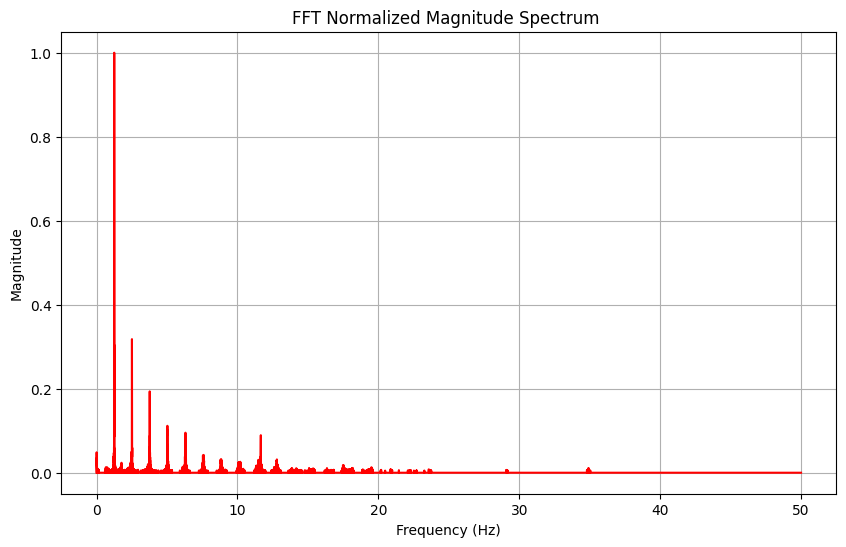

In [ ]:
plot_normalized_fft(df_fft, label_filtered)

In [ ]:
df

,Time,Z Acceleration,Z Corrected Acceleration,Z Corrected Filtered Acceleration
0,0.01,-0.012671,-0.018050,-0.007987
1,0.02,-0.012153,-0.017532,-0.008556
2,0.03,-0.011912,-0.017292,-0.010831
3,0.04,-0.016169,-0.021548,-0.013499
4,0.05,-0.015559,-0.020938,-0.009355
...,...,...,...,...
67103,671.04,0.009323,0.000638,-0.004353
67104,671.05,0.010082,0.001397,-0.003433
67105,671.06,0.008989,0.000305,-0.004433
67106,671.07,0.007972,-0.000713,-0.002648


In [ ]:
calculate_fft(df, label)

,Frequency,Z Magnitude
0,0.000000,471.904141
1,0.001490,35.600047
2,0.002980,36.800207
3,0.004470,22.761380
4,0.005961,18.043978
...,...,...
33549,49.992549,1.160889
33550,49.994039,0.954037
33551,49.995530,1.000810
33552,49.997020,1.357499


In [ ]:
def cwt_analysis(
    df: pd.DataFrame,
    label: str,
    wavelet: str = "cmor1.5-1.0",
    min_scale: int = 1,
    max_scale: int = 32,
):
    """
    Performs Continuous Wavelet Transform (CWT) analysis on acceleration data.

    Args:
        df: DataFrame containing 'Time' and '{label} Acceleration' columns.
        label: Direction of the acceleration data (e.g., 'X', 'Y', 'Z').
        wavelet: Wavelet function to use (default: 'cmor1.5-1.0').
        min_scale: Minimum scale for CWT (default: 1).
        max_scale: Maximum scale for CWT (default: 32).

    Returns:
        A tuple containing:
            - spectrum: Magnitude spectrum of the CWT coefficients.
            - frequencies: Frequencies corresponding to the scales.

    Assumptions:
        - 'df' contains 'Time' and '{label} Acceleration' columns.
        - 'Time' data is uniformly sampled.
        - 'label' is a valid column in df
    """
    # Validations
    if f"{label} Acceleration" not in df.columns:
        raise ValueError(f"{label} Acceleration is not found in DataFrame.")
    if "Time" not in df.columns:
        raise ValueError("The DataFrame must contain a 'Time' column.")

    time_step = df["Time"].iloc[1] - df["Time"].iloc[0]

    scales = np.arange(min_scale, max_scale)
    coefficients, frequencies = pywt.cwt(
        df[f"{label} Acceleration"], scales, wavelet, time_step
    )

    # Magnitude spectrum
    spectrum = np.abs(coefficients)

    return (spectrum, frequencies)

In [ ]:
wavelet ='morl'
min_scale = 2
max_scale = 160

In [ ]:
spectrum, frequencies = cwt_analysis(df, label, wavelet, min_scale, max_scale)

In [ ]:
def analyze_wavelet_spectrum(df: pd.DataFrame, label: str, wavelet: str='cmor1.5-1.0',
                             min_scale: float=2.0, max_scale: float=160) -> None:
    """
    Applies Continuous Wavelet Transform (CWT) to label_filtered acceleration data,
    calculates the average spectrum, and visualizes the time-frequency-magnitude spectrum.

    Args:
        df: DataFrame with 'Time' and at least one acceleration column.
        acceleration_column: Name of the acceleration column to analyze.
        wavelet: Wavelet function to use.
        min_scale: Minimum scale for the wavelet transform.
        max_scale: Maximum scale for the wavelet transform.

    Returns:
        None (displays the interactive 3D plot).
    """
   
    spectrum, frequencies = cwt_analysis(df, label, wavelet, min_scale, max_scale)
    time_step = df["Time"].iloc[1] - df["Time"].iloc[0]
    sampling_rate = 1 / time_step
    nyquist_freq = sampling_rate / 2
            # Minimum and maximum values for sliders
    time_min, time_max = df["Time"].min(), df["Time"].max()
    freq_min, freq_max = frequencies.min(), nyquist_freq

    def plot_wavelet_spectrum(elevation=0, rotation=0, label_size=10,
                              min_time=time_min, max_time=time_max, 
                              min_frequency=freq_min, max_frequency=freq_max):
        # Filtrar el rango de tiempo y frecuencia
        mask_x = (df['Time'] >= min_time) & (df['Time'] <= max_time)
        mask_y = (frequencies >= min_frequency) & (frequencies <= max_frequency)

        time_label_filtered = df['Time'][mask_x].values
        frequencies_label_filtered = frequencies[mask_y]
        spectrum_label_filtered = spectrum[np.ix_(mask_y, mask_x)]

        # Crear la malla para el gráfico
        X, Y = np.meshgrid(time_label_filtered, frequencies_label_filtered)

        # Verificar dimensiones
        if X.shape != spectrum_label_filtered.shape:
            print(f"Shape mismatch: X{X.shape}, Y{Y.shape}, Z{spectrum_label_filtered.shape}")
            return

        # Crear la figura 3D
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, spectrum_label_filtered, cmap='viridis')
        # ax.plot_surface(X, Y, spectrum_label_filtered, cmap='plasma')

        ax.set_xlabel('Time (s)', fontsize=label_size)
        ax.set_ylabel('Frequency (Hz)', fontsize=label_size)
        ax.set_zlabel('Magnitude', fontsize=label_size)
        ax.set_title('Time - Frequency - Magnitude Wavelet Spectrum', fontsize=label_size)
        ax.view_init(elev=elevation, azim=rotation)
        plt.show()

    # Crear controles interactivos
    widgets.interact(
        plot_wavelet_spectrum,
        elevation=(0, 360, 10),
        rotation=(0, 360, 10),
        label_size=(6, 32, 2),
        min_time=(time_min, time_max, (time_max - time_min) / 100),
        max_time=(time_min, time_max, (time_max - time_min) / 100),
        min_frecuency=(freq_min, freq_max, (freq_max - freq_min) / 50),
        max_frequency=(freq_min, freq_max, (freq_max - freq_min) / 50)
    ) 

In [ ]:
analyze_wavelet_spectrum(df, label_filtered, wavelet, min_scale, max_scale)

interactive(children=(IntSlider(value=0, description='elevation', max=360, step=10), IntSlider(value=0, descri…

In [ ]:
def plot_wavelet_spectra(
    df: pd.DataFrame,
    spectrum: np.ndarray,
    frequencies: np.ndarray,
    label: str,
    elevation: int = 0,
    rotation: int = 0,
    label_size: int = 10,
    label_offset: float = 0.1,
):
    """
    Plots the time-frequency-magnitude wavelet spectrum in four subplots: XY, XZ, YZ, and 3D.

    Args:
        df: DataFrame containing the 'Time' column.
        spectrum: Magnitude spectrum of the CWT coefficients.
        frequencies: Frequencies corresponding to the scales.
        label: Direction of the acceleration data (e.g., 'X', 'Y', 'Z').
        elevation: Elevation angle for the 3D plot (default: 0).
        rotation: Rotation angle for the 3D plot (default: 0).
        label_size: Font size for labels (default: 10).
        label_offset: Offset for labels (default: 0.1).

    Returns:
        None (displays the subplots).
    """
    time_step = df["Time"].iloc[1] - df["Time"].iloc[0]
    sampling_rate = 1 / time_step
    nyquist_freq = sampling_rate / 2

    time_min, time_max = df["Time"].min(), df["Time"].max()
    freq_min, freq_max = frequencies.min(), nyquist_freq

    mask_x = (df["Time"] >= time_min) & (df["Time"] <= time_max)
    mask_y = (frequencies >= freq_min) & (frequencies <= freq_max)

    time_filtered = df["Time"][mask_x].values
    frequencies_filtered = frequencies[mask_y]
    spectrum_filtered = spectrum[np.ix_(mask_y, mask_x)]

    X, Y = np.meshgrid(time_filtered, frequencies_filtered)

    if X.shape != spectrum_filtered.shape:
        print(
            f"Shape mismatch: X{X.shape}, Y{Y.shape}, spectrum{spectrum_filtered.shape}"
        )
        return

    fig = plt.figure(figsize=(20, 15))

    # XY subplot (Top View)
    ax1 = fig.add_subplot(221)
    c1 = ax1.contourf(X, Y, spectrum_filtered, cmap="viridis")
    ax1.set_xlabel("Time (s)", fontsize=label_size, labelpad=label_offset)
    ax1.set_ylabel("Frequency (Hz)", fontsize=label_size, labelpad=label_offset)
    ax1.set_title(f"{label} Wavelet Spectrum (Top View)", fontsize=label_size)
    fig.colorbar(c1, ax=ax1)

    # XZ subplot (Side View 1)
    ax2 = fig.add_subplot(222)
    c2 = ax2.contourf(
        X, spectrum_filtered, Y, cmap="viridis"
    )  # Swapped Y and spectrum_filtered for side view
    ax2.set_xlabel("Time (s)", fontsize=label_size, labelpad=label_offset)
    ax2.set_ylabel("Magnitude", fontsize=label_size, labelpad=label_offset)
    ax2.set_title(f"{label} Wavelet Spectrum (Side View 1)", fontsize=label_size)
    fig.colorbar(c2, ax=ax2)

    # YZ subplot (Side View 2)
    ax3 = fig.add_subplot(223)
    c3 = ax3.contourf(
        spectrum_filtered, Y, X, cmap="viridis"
    )  # Swapped X and spectrum_filtered for side view
    ax3.set_xlabel("Magnitude", fontsize=label_size, labelpad=label_offset)
    ax3.set_ylabel("Frequency (Hz)", fontsize=label_size, labelpad=label_offset)
    ax3.set_title(f"{label} Wavelet Spectrum (Side View 2)", fontsize=label_size)
    fig.colorbar(c3, ax=ax3)

    # 3D subplot
    ax4 = fig.add_subplot(224, projection="3d")
    ax4.plot_surface(X, Y, spectrum_filtered, cmap="viridis")
    ax4.set_xlabel("Time (s)", fontsize=label_size, labelpad=label_offset)
    ax4.set_ylabel("Frequency (Hz)", fontsize=label_size, labelpad=label_offset)
    ax4.set_zlabel("Magnitude", fontsize=label_size, labelpad=label_offset)
    ax4.set_title(f"{label} Wavelet Spectrum (3D View)", fontsize=label_size)
    ax4.view_init(elev=elevation, azim=rotation)

    box = ax4.get_position()
    y_height = box.height * 1.2  # Increase height by 20%
    ax4.set_position([box.x0, box.y0, box.width, y_height])

    plt.tight_layout()
    plt.show()

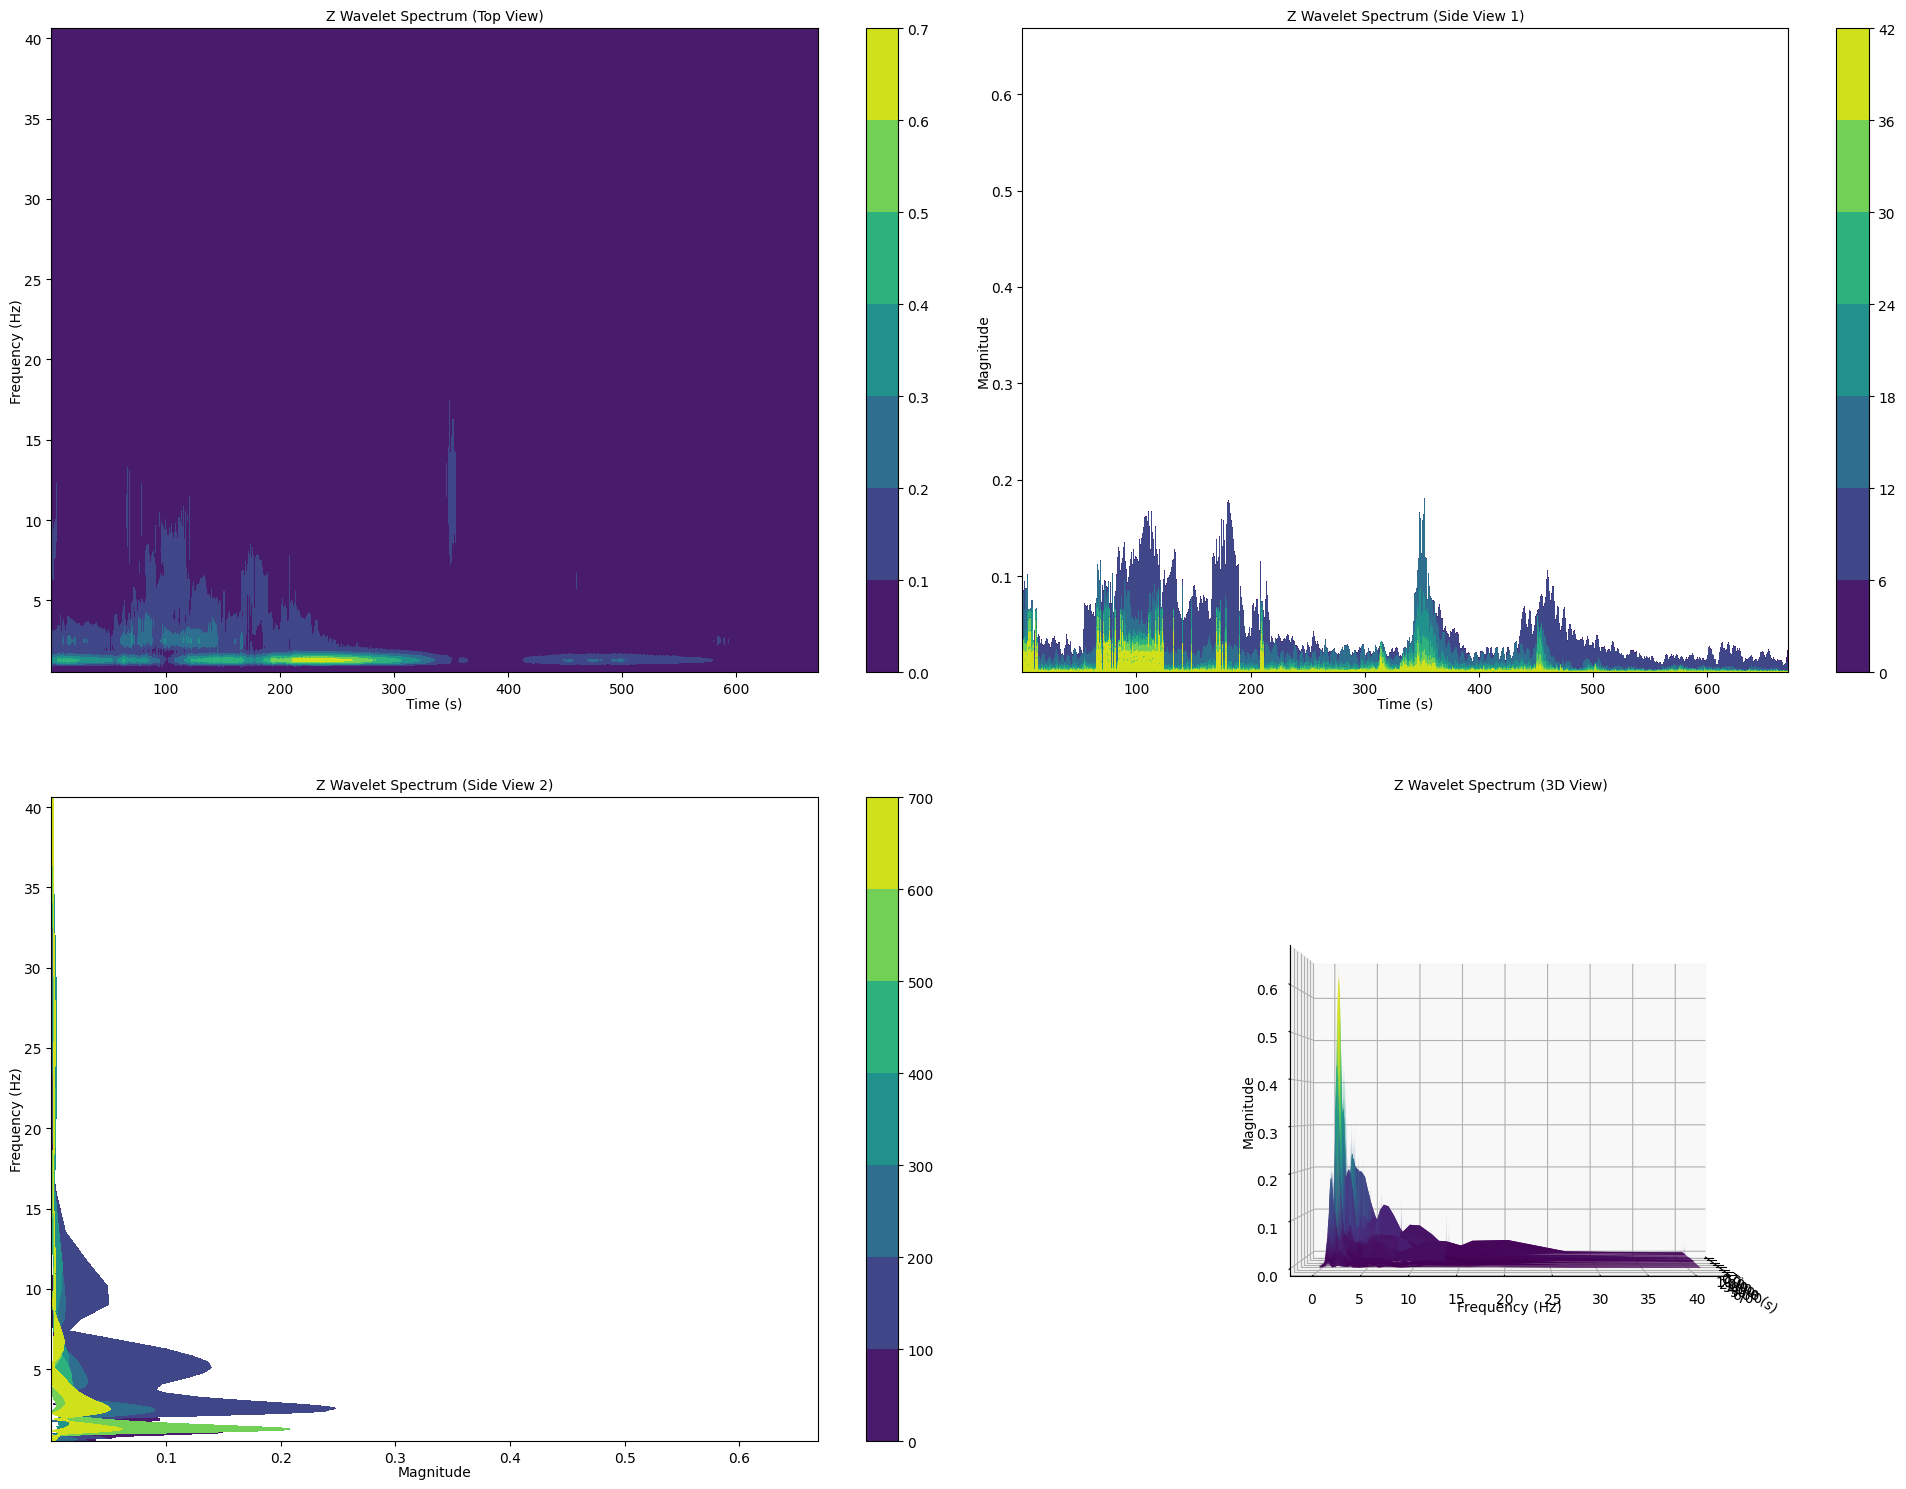

In [ ]:
plot_wavelet_spectra(
    df,
    spectrum,
    frequencies,
    label
)

In [ ]:
def plot_wavelet_spectra_tf(
    df: pd.DataFrame,
    spectrum: np.ndarray,
    frequencies: np.ndarray,
    label: str,
    elevation: int = 0,
    rotation: int = 0,
    label_size: int = 10,
    label_offset: float = 0.1,
):
    """
    Plots the time-frequency wavelet spectrum (Top View).

    Args:
        df: DataFrame containing the 'Time' column.
        spectrum: Magnitude spectrum of the CWT coefficients.
        frequencies: Frequencies corresponding to the scales.
        label: Direction of the acceleration data (e.g., 'X', 'Y', 'Z').
        elevation: Elevation angle for the 3D plot (default: 0).
        rotation: Rotation angle for the 3D plot (default: 0).
        label_size: Font size for labels (default: 10).
        label_offset: Offset for labels (default: 0.1).

    Returns:
        None (displays the plot).
    """
    time_step = df["Time"].iloc[1] - df["Time"].iloc[0]
    sampling_rate = 1 / time_step
    nyquist_freq = sampling_rate / 2

    time_min, time_max = df["Time"].min(), df["Time"].max()
    freq_min, freq_max = frequencies.min(), nyquist_freq

    mask_x = (df["Time"] >= time_min) & (df["Time"] <= time_max)
    mask_y = (frequencies >= freq_min) & (frequencies <= freq_max)

    time_filtered = df["Time"][mask_x].values
    frequencies_filtered = frequencies[mask_y]
    spectrum_filtered = spectrum[np.ix_(mask_y, mask_x)]

    X, Y = np.meshgrid(time_filtered, frequencies_filtered)

    if X.shape != spectrum_filtered.shape:
        print(
            f"Shape mismatch: X{X.shape}, Y{Y.shape}, spectrum{spectrum_filtered.shape}"
        )
        return

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    contour = ax.contourf(X, Y, spectrum_filtered, cmap="viridis")
    ax.set_xlabel("Time (s)", fontsize=label_size, labelpad=label_offset)
    ax.set_ylabel("Frequency (Hz)", fontsize=label_size, labelpad=label_offset)
    ax.set_title(f"{label} Wavelet Spectrum (Top View)", fontsize=label_size)
    fig.colorbar(contour, ax=ax)

    plt.tight_layout()
    plt.show()

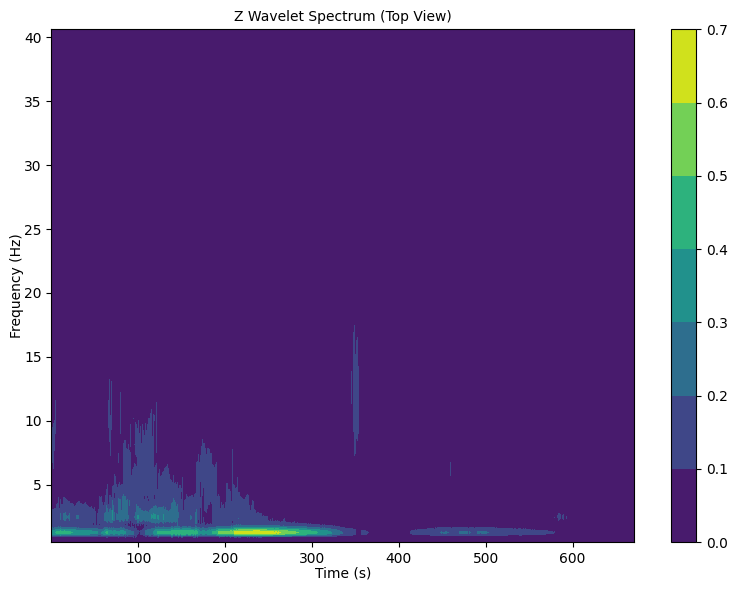

In [ ]:
plot_wavelet_spectra_tf(
    df,
    spectrum,
    frequencies,
    label
)

In [ ]:
def plot_wavelet_spectra_tm(
    df: pd.DataFrame,
    spectrum: np.ndarray,
    frequencies: np.ndarray,
    label: str,
    label_size: int = 10,
    label_offset: float = 0.1,
):
    """
    Plots the time-magnitude wavelet spectrum (Side View 1).

    Args:
        df: DataFrame containing the 'Time' column.
        spectrum: Magnitude spectrum of the CWT coefficients.
        frequencies: Frequencies corresponding to the scales.
        label: Direction of the acceleration data (e.g., 'X', 'Y', 'Z').
        label_size: Font size for labels (default: 10).
        label_offset: Offset for labels (default: 0.1).

    Returns:
        None (displays the plot).
    """
    time_min, time_max = df["Time"].min(), df["Time"].max()
    freq_min, freq_max = frequencies.min(), frequencies.max()

    mask_x = (df["Time"] >= time_min) & (df["Time"] <= time_max)
    mask_y = (frequencies >= freq_min) & (frequencies <= freq_max)

    time_filtered = df["Time"][mask_x].values
    frequencies_filtered = frequencies[mask_y]
    spectrum_filtered = spectrum[np.ix_(mask_y, mask_x)]

    X, Y = np.meshgrid(time_filtered, frequencies_filtered)

    if X.shape != spectrum_filtered.shape:
        print(
            f"Shape mismatch: X{X.shape}, Y{Y.shape}, spectrum{spectrum_filtered.shape}"
        )
        return

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    contour = ax.contourf(
        X, spectrum_filtered, Y, cmap="viridis"
    )  # Transpose spectrum

    ax.set_xlabel("Time (s)", fontsize=label_size, labelpad=label_offset)
    ax.set_ylabel("Magnitude", fontsize=label_size, labelpad=label_offset)
    ax.set_title(f"{label} Wavelet Spectrum (Side View 1)", fontsize=label_size)

    fig.colorbar(contour, ax=ax)

    plt.tight_layout()
    plt.show()

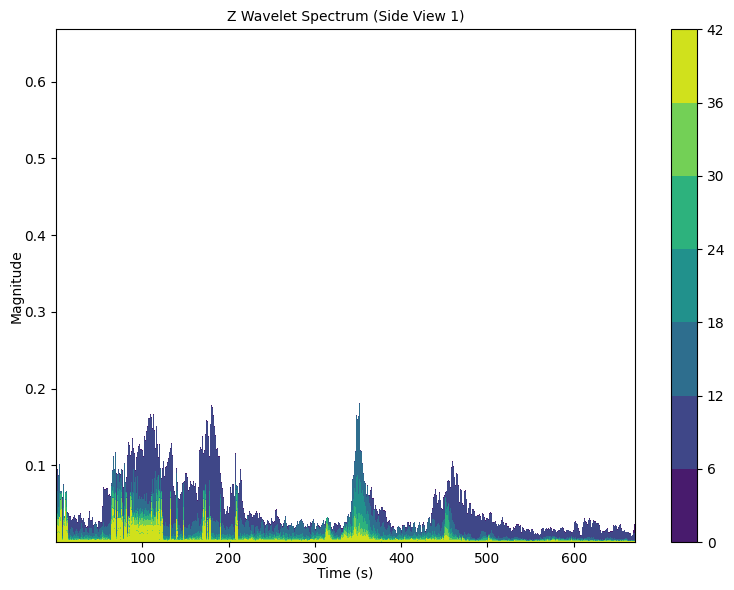

In [ ]:
plot_wavelet_spectra_tm(
    df,
    spectrum,
    frequencies,
    label
)

In [ ]:
def plot_wavelet_spectra_fm(
    df: pd.DataFrame,
    spectrum: np.ndarray,
    frequencies: np.ndarray,
    label: str,
    label_size: int = 10,
    label_offset: float = 0.1,
):
    """
    Plots the frequency-magnitude wavelet spectrum (Side View 2).

    Args:
        df: DataFrame containing the 'Time' column.
        spectrum: Magnitude spectrum of the CWT coefficients.
        frequencies: Frequencies corresponding to the scales.
        label: Direction of the acceleration data (e.g., 'X', 'Y', 'Z').
        label_size: Font size for labels (default: 10).
        label_offset: Offset for labels (default: 0.1).

    Returns:
        None (displays the plot).
    """
    time_min, time_max = df["Time"].min(), df["Time"].max()
    freq_min, freq_max = frequencies.min(), frequencies.max()

    mask_x = (df["Time"] >= time_min) & (df["Time"] <= time_max)
    mask_y = (frequencies >= freq_min) & (frequencies <= freq_max)

    time_filtered = df["Time"][mask_x].values
    frequencies_filtered = frequencies[mask_y]
    spectrum_filtered = spectrum[np.ix_(mask_y, mask_x)]

    X, Y = np.meshgrid(time_filtered, frequencies_filtered)

    if X.shape != spectrum_filtered.shape:
        print(
            f"Shape mismatch: X{X.shape}, Y{Y.shape}, spectrum{spectrum_filtered.shape}"
        )
        return

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    c = ax.contourf(
        spectrum_filtered, Y, X, cmap="viridis"
    )  # Swapped X and spectrum_filtered for side view
    ax.set_xlabel("Magnitude", fontsize=label_size, labelpad=label_offset)
    ax.set_ylabel("Frequency (Hz)", fontsize=label_size, labelpad=label_offset)
    ax.set_title(f"{label} Wavelet Spectrum (Side View 2)", fontsize=label_size)
    fig.colorbar(c, ax=ax)

    plt.tight_layout()
    plt.show()

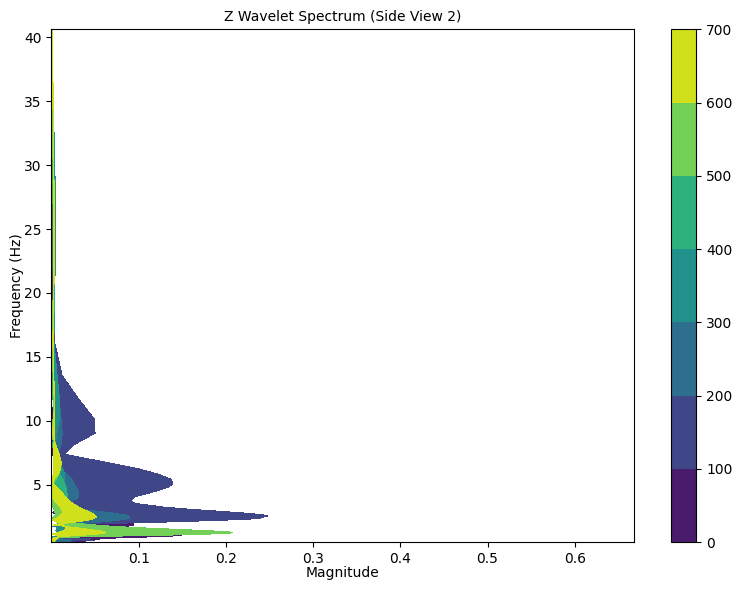

In [ ]:
plot_wavelet_spectra_fm(
    df,
    spectrum,
    frequencies,
    label
)

In [ ]:
df

,Time,Z Acceleration,Z Corrected Acceleration,Z Corrected Filtered Acceleration
0,0.01,-0.012671,-0.018050,-0.007987
1,0.02,-0.012153,-0.017532,-0.008556
2,0.03,-0.011912,-0.017292,-0.010831
3,0.04,-0.016169,-0.021548,-0.013499
4,0.05,-0.015559,-0.020938,-0.009355
...,...,...,...,...
67103,671.04,0.009323,0.000638,-0.004353
67104,671.05,0.010082,0.001397,-0.003433
67105,671.06,0.008989,0.000305,-0.004433
67106,671.07,0.007972,-0.000713,-0.002648


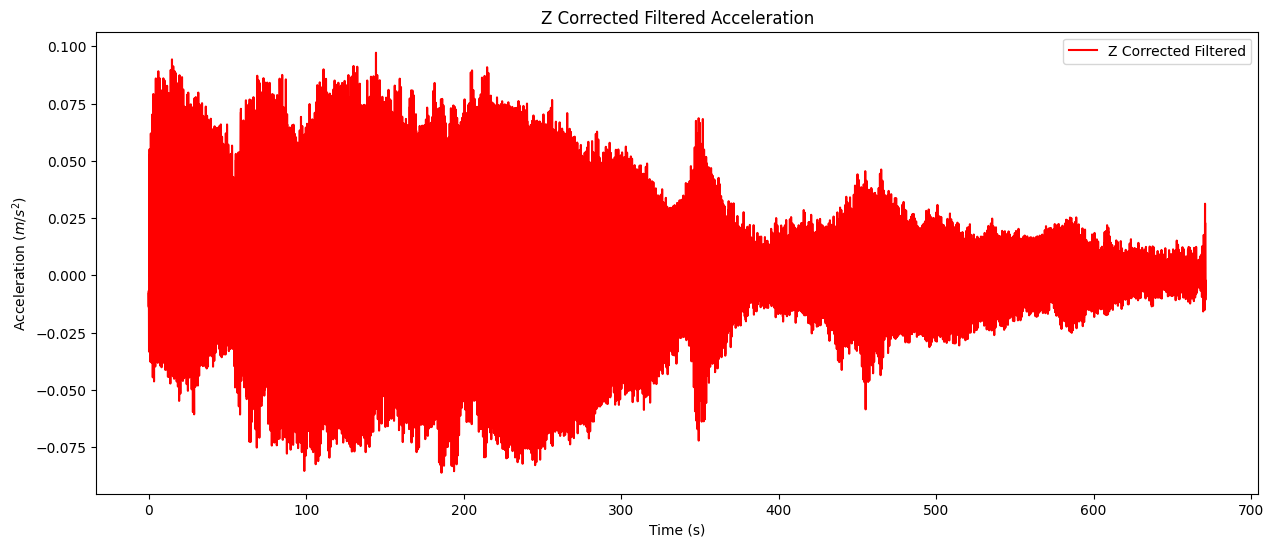

In [ ]:
plot_acceleration(df, label_filtered)

In [ ]:
df_fft = calculate_fft(df, label_filtered)

In [ ]:
df_fft

,Frequency,Z Corrected Filtered Magnitude
0,0.000000,1.013079e-15
1,0.001490,5.578962e+00
2,0.002980,2.130743e+01
3,0.004470,2.241619e+01
4,0.005961,2.560225e+01
...,...,...
33549,49.992549,4.062438e-15
33550,49.994039,6.584716e-15
33551,49.995530,2.918208e-15
33552,49.997020,2.971670e-15


In [ ]:
df_fft_filtered = calculate_fft(df, label_filtered)

In [ ]:
df_fft_filtered

,Frequency,Z Corrected Filtered Magnitude
0,0.000000,1.013079e-15
1,0.001490,5.578962e+00
2,0.002980,2.130743e+01
3,0.004470,2.241619e+01
4,0.005961,2.560225e+01
...,...,...
33549,49.992549,4.062438e-15
33550,49.994039,6.584716e-15
33551,49.995530,2.918208e-15
33552,49.997020,2.971670e-15


In [ ]:
t = df_fft_filtered['Frequency']
y = df_fft_filtered[f'{label_filtered} Magnitude']

In [ ]:
peaks_scipy, _ = signal.find_peaks(y, height=50)


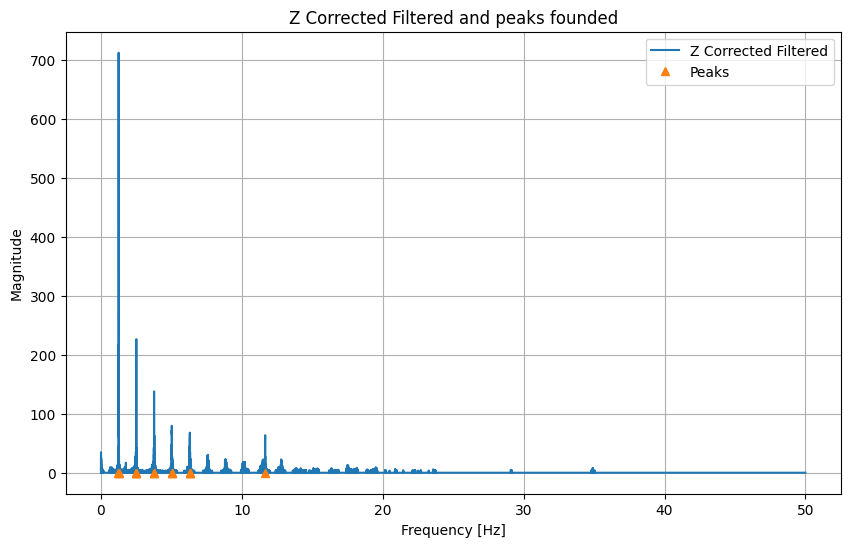

In [ ]:
# Grafica la señal original y los picos encontrados
plt.figure(figsize=(10, 6))

plt.plot(t, y, label=label_filtered)
plt.plot(t[peaks_scipy], np.interp(peaks_scipy, t, y), '^', label='Peaks')

plt.title(f'{label_filtered} and peaks founded')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()